This code uses the **Z3** solver to define boolean variables (features) for a customizable system.

The following features are defined:

- `CustomSBC`: Custom single-board computer.
- `Cpus`: Indicates if the CPU subsystem is used.
- `Memory`: Indicates if memory is present.
- `cpu0`, `cpu1`, `cpu2`: Three individual CPUs.

These features are stored in a list called `features`.

To organize the model:

- `cpu_vars`: List of CPU variables.
- `uart_vars` and `veth_vars`: Empty lists for UART and virtual Ethernet interfaces (reserved for future use).

This setup prepares the model for adding constraints and exploring valid configurations using Z3.

In [19]:
from z3 import *

# Define features
# CustomSBC, Cpus, Memory, uarts, vEthernet, cpu0, cpu1, cpu2, uart0, uart1, veth0, veth1, veth2 = Bools(
#     "CustomSBC Cpus Memory uarts vEthernet cpu0 cpu1 cpu2 uart0 uart1 veth0 veth1 veth2"
# )

# features = [
#     CustomSBC, Cpus, Memory, uarts, vEthernet, cpu0, cpu1, cpu2, uart0, uart1, veth0, veth1, veth2
# ]

CustomSBC, Cpus, Memory, cpu0, cpu1, cpu2 = Bools(
    "CustomSBC Cpus Memory cpu0 cpu1 cpu2"
)

features = [
    CustomSBC, Cpus, Memory, cpu0, cpu1, cpu2
]
cpu_vars = [cpu0, cpu1, cpu2]
# uart_vars = [uart0, uart1]
# veth_vars = [veth0, veth1, veth2]
uart_vars = []
veth_vars = []

The `base_constraints(alpha, beta)` function defines the main rules (constraints) of the model using the Z3 solver.

This setup is used to generate valid system configurations within the defined CPU limits.

In [20]:
# Core constraints
def base_constraints(alpha, beta):
    s = Solver()
    s.add(CustomSBC)
    s.add(Cpus == CustomSBC)
    s.add(Memory == CustomSBC)
    # s.add(Implies(uarts, CustomSBC))
    # s.add(Implies(vEthernet, CustomSBC))
    s.add(Sum([If(c, 1, 0) for c in cpu_vars]) >= alpha)
    s.add(Sum([If(c, 1, 0) for c in cpu_vars]) <= beta)
    s.add(Or(cpu0, cpu1, cpu2) == Cpus)
    # s.add(Or(uart0, uart1) == uarts)
    # s.add(Or(veth0, veth1, veth2) == vEthernet)
    # s.add(Not(And(veth0, veth1)))
    # s.add(Not(And(veth0, veth2)))
    # s.add(Not(And(veth1, veth2)))
    # s.add(Implies(veth0, cpu0))
    # s.add(Implies(veth1, cpu1))
    # s.add(Implies(veth2, cpu2))
    return s

The `generate_tree` function builds a decision tree of possible product configurations based on the Z3 constraints and available variables.

This function is used to generate a **tree of valid products** for given values of `alpha` (minimum CPUs) and `beta` (maximum CPUs). Each path in the tree represents a valid configuration that satisfies the constraints.

This function helps visualize all possible valid configurations (products) based on the constraints defined by `alpha` and `beta`.

In [21]:
# Tree generation (no null branches)
def generate_tree(solver, decisions, remaining_vars):
    for d in decisions:
        solver.add(d)
    if solver.check() == unsat:
        return None

    if not remaining_vars:
        model = solver.model()
        config = [f.decl().name() for f in features if is_true(model[f])]
        return {"config": config}

    var = remaining_vars[0]

    # Explore var = True
    left_solver = Solver()
    left_solver.append(solver.assertions())
    left_branch = generate_tree(left_solver, decisions + [var], remaining_vars[1:])

    # Explore var = False
    right_solver = Solver()
    right_solver.append(solver.assertions())
    right_branch = generate_tree(right_solver, decisions + [Not(var)], remaining_vars[1:])

    # Build decision node only with non-null branches
    if left_branch and right_branch:
        return {
            "decision": var.decl().name(),
            "true": left_branch,
            "false": right_branch
        }
    elif left_branch:
        return {
            "decision": var.decl().name(),
            "true": left_branch
        }
    elif right_branch:
        return {
            "decision": var.decl().name(),
            "false": right_branch
        }
    else:
        return None

This part of the code interacts with the user to define constraints and preferences for generating valid configurations.

This step allows the user to customize the configuration and narrow down the search space before generating the tree of valid products.

In [22]:
# User interaction to collect alpha and beta
while True:
    try:
        alpha = int(input("Enter alpha value (minimum CPUs, ≥ 0): "))
        if alpha <= 0:
            print("Alpha must be greater than or equal to 0.")
            continue
        break
    except ValueError:
        print("Please enter a valid integer for alpha.")

while True:
    try:
        beta = int(input(f"Enter beta value (maximum CPUs, ≥ {alpha}): "))
        if beta < alpha:
            print(f"Beta must be greater than or equal to alpha ({alpha}).")
            continue
        break
    except ValueError:
        print("Please enter a valid integer for beta.")

user_choices = {}
for var in cpu_vars:
    answer = input(f"Activate {var.decl().name()}? (y/n): ").strip().lower()
    if answer == "y":
        user_choices[var] = True
    elif answer == "n":
        user_choices[var] = False
    else:
        pass

Enter alpha value (minimum CPUs, ≥ 0):  1
Enter beta value (maximum CPUs, ≥ 1):  2
Activate cpu0? (y/n):  
Activate cpu1? (y/n):  
Activate cpu2? (y/n):  


In [23]:
# Prepare initial decisions
initial_decisions = [k if v else Not(k) for k, v in user_choices.items()]
used_vars = set(user_choices.keys())

# Remaining variables to explore
all_decision_vars = [f for f in cpu_vars + uart_vars + veth_vars if f not in used_vars]

# Build and explore the tree
solver = base_constraints(alpha, beta)
tree = generate_tree(solver, initial_decisions, all_decision_vars)

This part of the code visualizes the **decision tree of possible products** generated based on the user-defined constraints (`alpha`, `beta`, and selected CPUs).

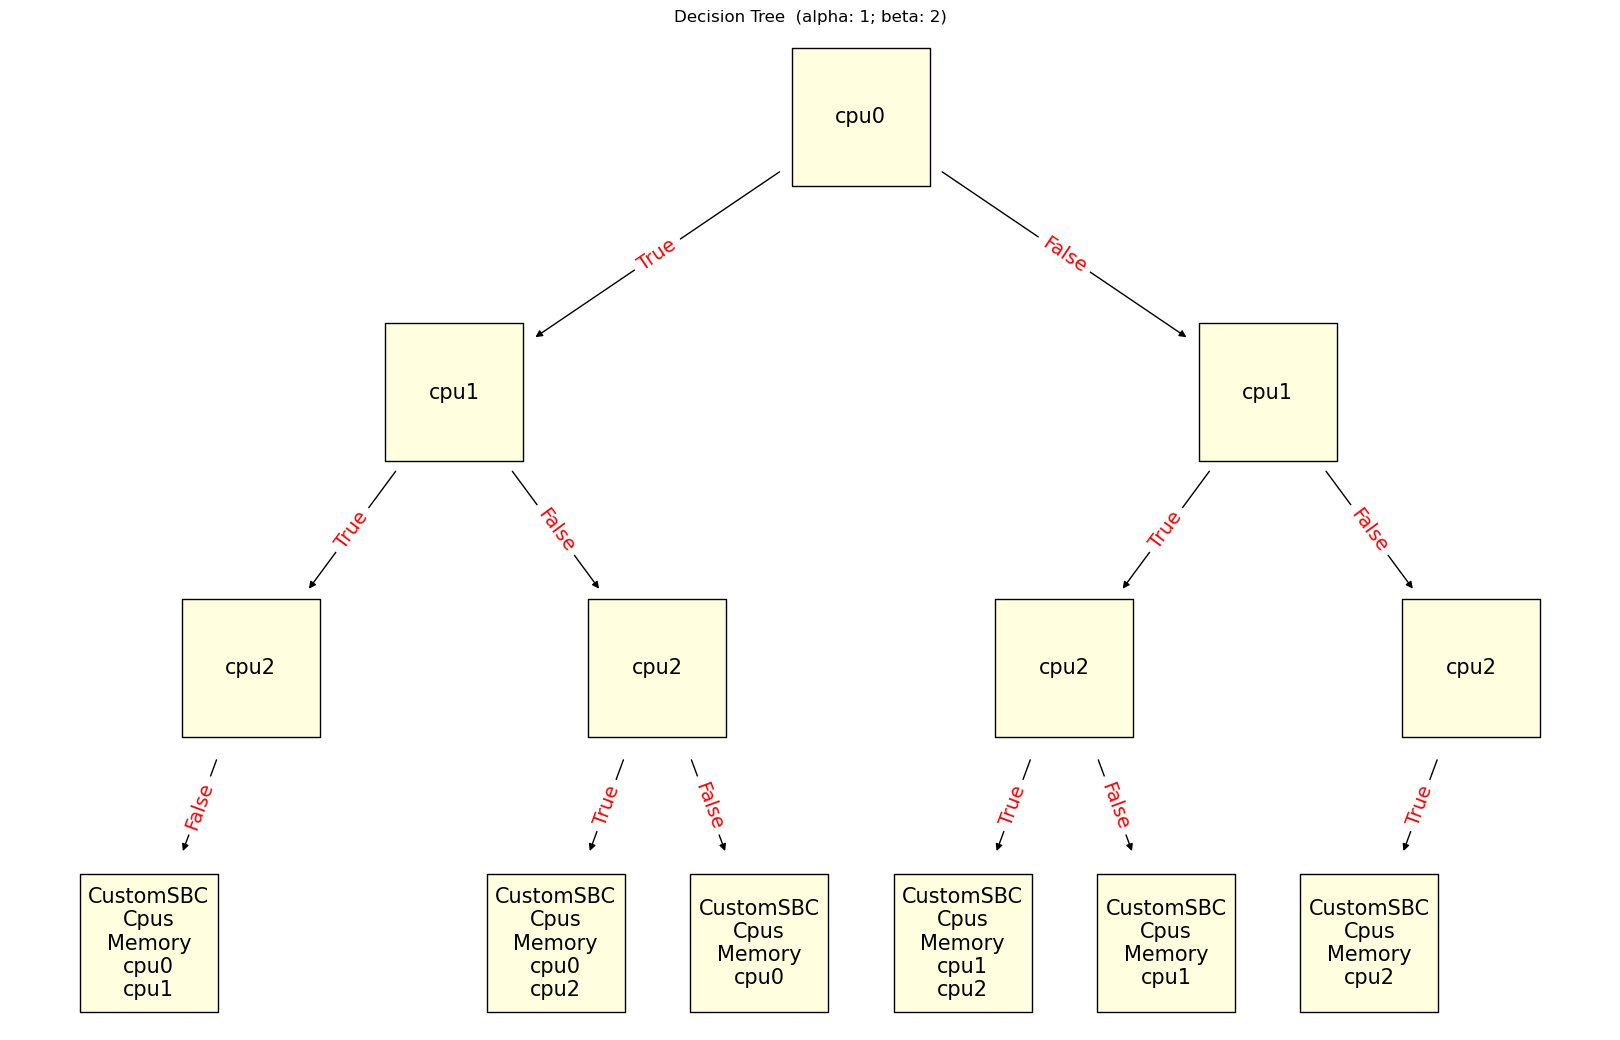

In [33]:
import matplotlib.pyplot as plt
import networkx as nx

def build_tree_graph(tree, graph=None, parent=None, edge_label="", counter=[0], pos=None, x=0, y=0, dx=1):
    if graph is None:
        graph = nx.DiGraph()
        pos = {}

    node_id = counter[0]
    counter[0] += 1

    if "decision" in tree:
        label = tree["decision"]
    else:
        label = "\n".join(tree["config"])

    graph.add_node(node_id, label=label)
    pos[node_id] = (x, y)

    if parent is not None:
        graph.add_edge(parent, node_id, label=edge_label)

    children = []
    if "true" in tree:
        children.append(("True", tree["true"]))
    if "false" in tree:
        children.append(("False", tree["false"]))

    n = len(children)
    for i, (branch_label, child_tree) in enumerate(children):
        child_x = x - dx/2 + i * dx
        child_y = y - 1
        build_tree_graph(child_tree, graph, node_id, branch_label, counter, pos, child_x, child_y, dx/2)

    return graph, pos

if tree:
    G, pos = build_tree_graph(tree, dx=8)

    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(16, 10))
    nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightyellow',
            node_size=10000, font_size=15, edgecolors='black', node_shape='s')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14, font_color='red')
    plt.title(f"Decision Tree {user_choices if user_choices else ''} (alpha: {alpha}; beta: {beta})")
    plt.axis('off')
    plt.show()

This code builds an **expanded decision tree** that groups all valid product configurations.

The function `generate_tree_with_groups` creates groups of valid configurations (products) using the Z3 solver.
After finding one valid configuration, it excludes the CPUs used and generates a new group.
This process repeats until no more valid configurations can be found.

- `collect_all_configs`: collects all valid configurations (leaf nodes) in a tree.
- `compute_subtree_width`: calculates how wide each part of the tree is, to help with clean graph layout.
- `build_tree_graph`: draws the tree with NetworkX and Matplotlib, showing decisions and grouped products clearly.

This part of the code is used to generate and display **all valid and independent groups of products**, based on CPU combinations and user-defined constraints (`alpha`, `beta`).

In [29]:
# Expanded tree with groups
def generate_tree_with_groups(solver, decisions, remaining_vars, used_cpus, alpha, beta):
    solver.push()
    for d in decisions:
        solver.add(d)

    if solver.check() == unsat:
        solver.pop()
        return None

    if not remaining_vars:
        model = solver.model()
        config = [f.decl().name() for f in features if is_true(model[f])]
        cpus_in_config = [name for name in config if name.startswith("cpu")]
        new_used_cpus = used_cpus.union(cpus_in_config)

        exclusions = [Not(v) for v in cpu_vars if v.decl().name() in new_used_cpus]
        new_solver = base_constraints(0, len(cpu_vars))
        subtree = generate_tree_with_groups(
            new_solver,
            exclusions,
            [v for v in cpu_vars if v.decl().name() not in new_used_cpus],
            new_used_cpus,
            0, len(cpu_vars)
        )

        solver.pop()
        node = {"config": config}
        if subtree:
            node["next"] = subtree
        return node

    var = remaining_vars[0]

    # True branch
    solver.push()
    solver.add(var)
    left_branch = generate_tree_with_groups(
        solver, [], remaining_vars[1:], used_cpus, alpha, beta
    )
    solver.pop()

    # False branch
    solver.push()
    solver.add(Not(var))
    right_branch = generate_tree_with_groups(
        solver, [], remaining_vars[1:], used_cpus, alpha, beta
    )
    solver.pop()

    solver.pop()

    if left_branch and right_branch:
        return {"decision": var.decl().name(), "true": left_branch, "false": right_branch}
    elif left_branch:
        return {"decision": var.decl().name(), "true": left_branch}
    elif right_branch:
        return {"decision": var.decl().name(), "false": right_branch}
    else:
        return None

# Collect all possible configs from a subtree
def collect_all_configs(node):
    configs = []
    def dfs(n):
        if not isinstance(n, dict): return
        if "config" in n: configs.append(n)
        if "true" in n: dfs(n["true"])
        if "false" in n: dfs(n["false"])
        if "next" in n: dfs(n["next"])
    dfs(node)
    return configs

# Cache widths to avoid recomputation
def compute_subtree_width(node, cache=None):
    if cache is None:
        cache = {}
    node_id = id(node)
    if node_id in cache:
        return cache[node_id]

    if not isinstance(node, dict):
        cache[node_id] = 1
        return 1

    if "config" in node and "next" not in node:
        cache[node_id] = 1
        return 1

    widths = []
    if "true" in node:
        widths.append(compute_subtree_width(node["true"], cache))
    if "false" in node:
        widths.append(compute_subtree_width(node["false"], cache))
    if "next" in node:
        configs = collect_all_configs(node["next"])
        widths.append(len(configs))

    total = max(1, sum(widths))
    cache[node_id] = total
    return total

# Visual construction of the graph with width caching
def build_tree_graph(tree, graph=None, parent=None, edge_label="", counter=[0], pos=None, x=0, y=0, dx=1, width_cache=None):
    if graph is None:
        graph = nx.DiGraph()
        pos = {}
        width_cache = {}

    node_id = counter[0]
    counter[0] += 1

    label = tree["decision"] if "decision" in tree else "\n".join(tree["config"])
    graph.add_node(node_id, label=label)
    pos[node_id] = (x, y)

    if parent is not None:
        graph.add_edge(parent, node_id, label=edge_label)

    children = []
    if "true" in tree:
        children.append(("True", tree["true"]))
    if "false" in tree:
        children.append(("False", tree["false"]))
    if "next" in tree:
        configs = collect_all_configs(tree["next"])
        for cfg in configs:
            children.append(("And", cfg))

    total_width = sum(compute_subtree_width(child[1], width_cache) for child in children)
    child_x = x - (dx * total_width) / 2
    for label, subtree in children:
        width = compute_subtree_width(subtree, width_cache)
        center_x = child_x + dx * width / 2
        build_tree_graph(subtree, graph, node_id, label, counter, pos, center_x, y - 2, dx, width_cache)
        child_x += dx * width

    return graph, pos

In [30]:
initial_decisions = [k if v else Not(k) for k, v in user_choices.items()]
used_vars = set(user_choices.keys())
all_decision_vars = [f for f in cpu_vars if f not in used_vars]

solver = base_constraints(alpha, beta)
tree = generate_tree_with_groups(solver, initial_decisions, all_decision_vars, set(), alpha, beta)

This part of the code is used to **extract and display product groups** from the expanded decision tree, where each group uses a **distinct set of all available CPUs**.

These functions help you explore the **final result of the tree**, showing which valid products belong to each **complete and independent group** of CPU assignments.

In [31]:
def extract_product_groups(tree):
    groups = []

    def dfs(node, current_path):
        if "config" in node:
            # Add the current configuration to the path
            new_path = current_path + [node["config"]]

            # If there's a "next", continue down that subtree
            if "next" in node:
                dfs(node["next"], new_path)
            else:
                groups.append(new_path)
            return

        if "true" in node:
            dfs(node["true"], current_path)
        if "false" in node:
            dfs(node["false"], current_path)

    dfs(tree, [])
    return groups

def print_product_groups(groups):
    for idx, group in enumerate(groups, start=1):
        print(f"\nGroup {idx}:")
        for config in group:
            print("  Product:", config)

groups = extract_product_groups(tree)
print_product_groups(groups)


Group 1:
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu0', 'cpu1']
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu2']

Group 2:
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu0', 'cpu2']
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu1']

Group 3:
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu0']
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu1', 'cpu2']

Group 4:
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu0']
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu1']
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu2']

Group 5:
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu0']
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu2']
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu1']

Group 6:
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu1', 'cpu2']
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu0']

Group 7:
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu1']
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu0', 'cpu2']

Group 8:
  Product: ['CustomSBC', 'Cpus', 'Memory', 'cpu1']
  Product: ['

This visualization shows the **entire solution space** as a decision tree, organized into **valid and disjoint product groups** that satisfy the given CPU constraints.

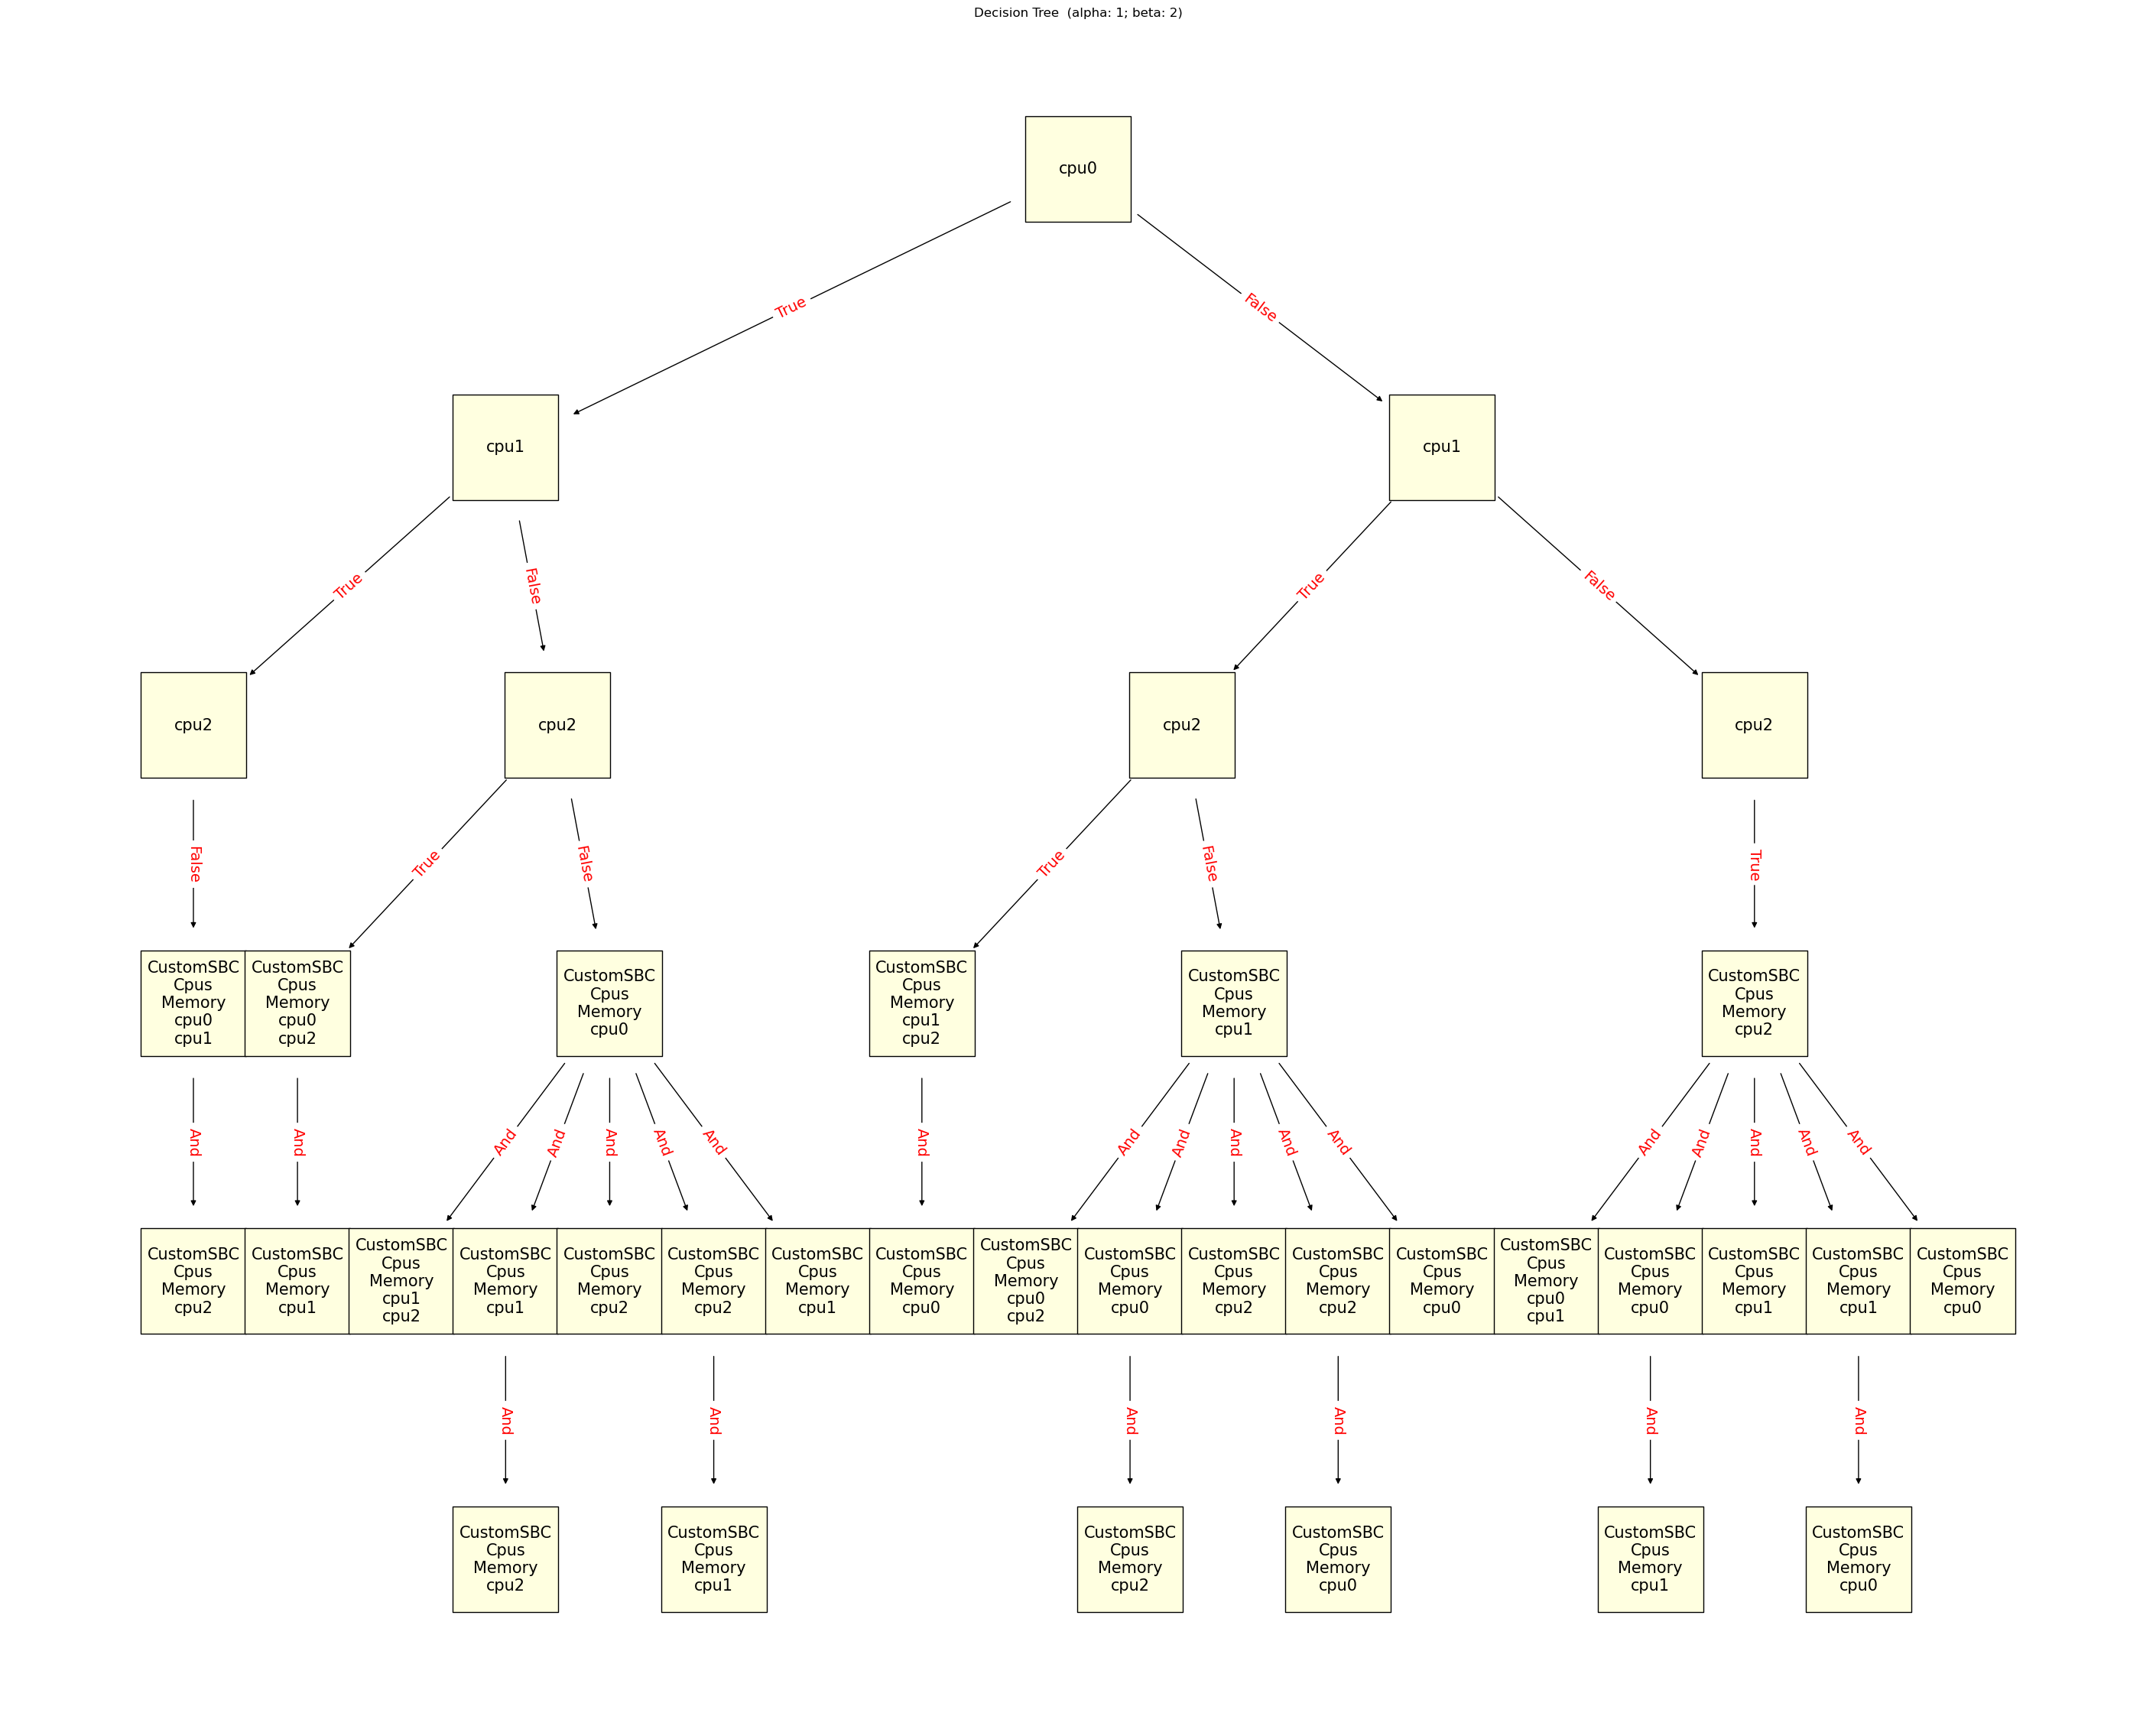

In [32]:
if tree:
    total_width = compute_subtree_width(tree)
    G, pos = build_tree_graph(tree, dx=2)
    labels = nx.get_node_attributes(G, 'label')
    edge_labels = nx.get_edge_attributes(G, 'label')

    plt.figure(figsize=(28, 22))
    nx.draw(G, pos, labels=labels, with_labels=True, node_color='lightyellow',
            node_size=10000, font_size=15, edgecolors='black', node_shape='s')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=14, font_color='red')
    plt.title(f"Decision Tree {user_choices if user_choices else ''} (alpha: {alpha}; beta: {beta})")
    plt.axis('off')
    plt.savefig("tree_example.png", bbox_inches='tight', dpi=300)
    plt.show()